# DCGAN on Bricks Dataset

In [1]:
import os
from PIL import Image

import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as Transforms

from matplotlib import pyplot as plt

## 0. Train Parameters

In [2]:
DATA_DIR = '../../data/Lego/dataset'
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

## 1. Prepare dataset

In [6]:
class LegoData(Dataset):

    def __init__(self, image_dir):
        super().__init__()
        self.image_dir = image_dir
        self.imgs = os.listdir(self.image_dir)
        self.length = len(self.imgs)

        # Define transforms
        self.transform = Transforms.Compose([
                            Transforms.ToTensor(),
                            Transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE), antialias=None),
                            Transforms.Grayscale(num_output_channels=1)
        ])

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        img_file = os.path.join(self.image_dir, self.imgs[index])
        img = Image.open(img_file)
        img = self.transform(img)
        return img

In [13]:
def get_dataloader():
    lego_dataset = LegoData(DATA_DIR)
    train_loader = DataLoader(lego_dataset, batch_size=BATCH_SIZE, num_workers=8,
                              shuffle=True, pin_memory=True)
    return train_loader

torch.Size([128, 1, 64, 64])


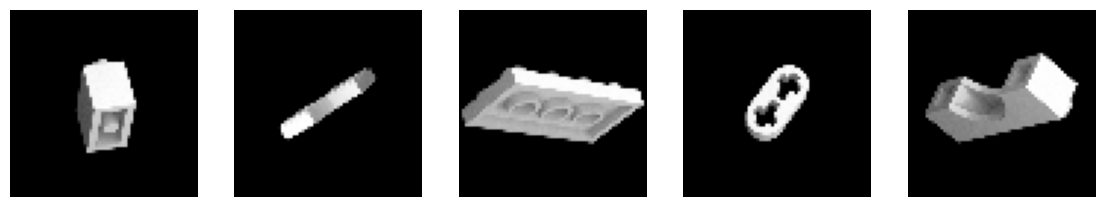

In [21]:
# Check dataset
train_loader = get_dataloader()
check_sample = next(iter(train_loader))
print(check_sample.shape)

plt.figure(figsize=(14, 3))
for i in range(5):
    ax = plt.subplot(1, 5, i+1)
    ax.imshow(check_sample[i][0], cmap='gray')
    ax.axis('off')

plt.show()

## Building GAN

In [23]:
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()
        